# Variational Inference: Spam Detection

In this assignment, we will load the UCI SMS Spam Collection dataset.
However, instead of using it directly, we will use fixed-size vector embeddings of the message.
Those embeddings have already been produced and are provided here to you.


## Setting the Scene

The goal of this assignment to go beyond a traditional classifier and apply variational methods.
This means that we will train a model using some parameters over the distribution of which we have a prior belief.
Our prior belief here is actually that each and every parameter independently follows a standard normal distribution.


During optimization, we will draw sets of parameters from our variational distribution $q_{\phi}$.
Drawing these parameters needs to be done using the reparameterization trick, so that we can add noise, i.e., $w_i=\mu_i+\sigma_i\cdot\epsilon$.
The assignment also poses one or the other question (clearly marked), you need to provide your answer directly after.


The assignment has some blank spots for you to fill out (but you can customize your implementation to your liking).
Training should be done using stochastic gradient descend, either using manual gradient updates or using an optimizer.

You should use autodiff-capabilities to compute gradients.
It is recommended to use, for example, JAX or PyTorch.
We recommend the latter, using it in a functional way (i.e., using `torch.func.jacrev`).
The blanks left in this assignment and their type hints assume PyTorch.
There are some cells with quick tests/sanity-checks, that you are free to remove, especially if they do not go along with how you chose to implement your solution.


At the end of the assignment, after training, you need to pick one advanced method of evaluation.
We are not interested in traditional metrics here (e.g., accuracy, Kappa, F1, etc.; although you are welcome to show those).
Rather, we want to exploit the variational nature of the model here and show something more interesting.

# Load the Data

You're variational model shall use no more than 15 components (aim for ~5 or fewer).
You'll have to apply a dimensionality reduction.

Sentence Embeddings were created in two ways:

1. (Recommended) Using [ALBERT XLarge v2](https://huggingface.co/albert/albert-xlarge-v2) (`albert-xlarge-v2`). Dim $=2,048$.
2. Using [English word vectors](https://fasttext.cc/docs/en/english-vectors.html) from `wiki-news-300d-1M` using `fasttext`. Dim $=300$.

In either case, the embeddings were averaged along the sequence dimension to produce fixed-size vectors.
In the provided dataset, the messages are retained.
This is useful should you choose a qualitative evaluation.

The labels have already been converted to floats: 0.0=ham, 1.0=spam.
The default example below shows a spam message.

In [99]:
# Modify only the file you wish to load.
# Each data file contains 3 keys: X, y, msg
import numpy as np

data = np.load(file='2048d_sms_spam_albert-xlarge-v2.npz')
# data = np.load(file='300d_sms_spam_fasttext_pca.npz')

X: np.ndarray; Y: np.ndarray
X, Y, msg = data.get('X'), data.get('y'), data.get('msg')
X.shape, Y.shape, len(msg), msg[2], Y[2]

((5572, 2048),
 (5572,),
 5572,
 np.str_("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"),
 np.int64(1))

# Define the Model

Our model is to be a polynomial with degree corresponding to the number of components chosen for the PCA.

$$
\begin{align}
    z=w_0+w_1\cdot x_1+w_2x_2^2+\dots+w_nx_n^n.
\end{align}
$$

We will perform a **binary** classification problem, using the binary cross-entropy (CE).
CE has a range of $[0,\infty)$.
The better the predictions of our model, the lower the CE.


Note that binary CE requires our predictions to be in the range $[0,1]$.
Therefore, we will have to pass its raw outputs ("logits") through the Sigmoid function.
This makes our model a **logistic** classifier.
The Sigmoid function is defined as $s(x)=\frac{1}{1+e^{-z}}$.

$$
\begin{align}
    p_i&=s(z_i),\;\text{convert our raw predictions to probabilities, then:}
    \\[1ex]
    \hat{y}_i&\sim\text{Bernoulli}(p_i).
\end{align}
$$


Since our predicted $\hat{y}$ will follow a Bernoulli distribution, we can directy use its likelihood function.
Note that maximizing the Bernoulli likelihood is equivalent of minimizing the binary CE!
The Bernoulli distribution is parameterized by a single parameter, **$p$**.


However, in our context, $p$ is unknown.
In order not to confuse the Bernoulli distribution's parameter $p$ with anything, in the following, we have substituted it with $s(z_i)$.
We will optimize for it, so that the output of our logisitic classifier becomes $p$.
The likelihood (for the prediction $\hat{y}_i$ of a single observation and its label $y_i$) then becomes:

$$
\begin{align}
    p(\mathbf{y}|\mathbf{X},\mathbf{w})&=\prod_i\,s(z_i)^{y_i}\cdot(1-s(z_i))^{1-y_i},
    \\
    \log{(p(\mathbf{y}|\mathbf{X},\mathbf{w}))}&=\sum_i\,\left[\log{(s(z_i)^{y_i})}+\log{((1-s(z_i))^{1-y_i})}\right],
    \\
    &=\sum_i\,\left[y_i\cdot\log{(s(z_i))} + (1-y_i)\cdot\log{(1-s(z_i))}\right].
\end{align}
$$

* Our **prior** belief is that each parameter follows a standard normal distribution, i.e., $w_j\sim\mathcal{N}(0,1)$.
* For our variational distribution, use a mean-field approximation of standard (independent) normals, too.


**Question**: Conceptually, how does the log-likelihood $p(y|x,w)$ compute its result given a single $n$-dimensional observation under the assumption of independent dimensions?

**Answer**: In case of independent dimensions, the (log-)likelihood across all dimensions is multiplied (summed).

# Implement the Model

Here, you are encouraged to use a library/framework like PyTorch or JAX and esp. functionality for automatic differentiation to compute gradients.
You may also import functions like `sigmoid` or `vmap` for vectorized operations.

It is recommended to implement vectorized versions of your required functions (i.e., batch-processing).

It is preferable to use type-hints for your functions.
Furthermore, you can write better code by inserting assertions (e.g., for dimensionality or other sanity-checks).
Please use Python-style comments like in the following:

```python
def func(w0: float, x: float) -> float:
    """
    Function to compute a multiple of x.
    """
    ...
```

In [100]:
import torch
from torch import Tensor

print(torch.__version__) # Just to check the version and that torch is loaded
print("CUDA available:", torch.cuda.is_available())


def model(w: Tensor, x: Tensor) -> Tensor:
    """
    Takes the coefficients w, the observations, computes the polynomial and
    returns probabilities.
    w: Tensor of shape (..., D+1) containing [w0, w1, ..., wD]
    x: Tensor of shape (N, D) containing D-dimensional inputs for N samples

    Returns:
        Tensor of shape (N,) with predicted probabilities in [0,1]
    """
    # Number of features
    D = x.shape[1]
    # Ensure w has D+1 coefficients
    assert w.shape[-1] == D + 1, f"Expected w[..., D+1], got {w.shape[-1]}"

    # Compute the polynomial z = w0 + w1*x1 + w2*(x2^2) + ... + wD*(xD^D)
    # Broadcast w terms against x dimensions
    z = w[..., 0]  # bias term, shape broadcastable to (N,)
    for j in range(1, D + 1):
        # x[:, j-1] raised to the j-th power, shape (N,)
        term = x[:, j-1] ** j
        # w[..., j] has shape like (...,)
        z = z + w[..., j] * term
    # Apply sigmoid to get probabilities
    return torch.sigmoid(z)


2.7.0+cpu
CUDA available: False


In [101]:
# Sanity-check, we should get 4 outputs if the model is correctly vectorized!
temp = model(w=torch.rand(size=(1,6)), x=torch.rand(size=(4,5)))
temp

# output that was provided (double check):
#tensor([0.7839, 0.7999, 0.7693, 0.8770])

tensor([0.8234, 0.6412, 0.6796, 0.6628])

## The Likelihood function

In [102]:
def log_lik(y_true: Tensor, y_hat: Tensor) -> Tensor:
    """
    For one or more observations, where y_true is the true label (0 or 1)
    and y_hat contains predicted probabilities [0,1], computes the (log)
    likelihood summed over all observations.

    Returns a single-element tensor.
    """
    # Avoid log(0) by clamping y_hat within (eps, 1-eps)
    eps = 1e-8
    p = y_hat.clamp(min=eps, max=1.0 - eps)
    # Log-likelihood: sum_i [y_i*log(p_i) + (1-y_i)*log(1-p_i)]
    ll = (y_true * torch.log(p) + (1 - y_true) * torch.log(1 - p)).sum()
    return ll

In [103]:
# Sanity-check, should be a single element here:
log_lik(y_true=torch.tensor(data=[1,0,1,0], dtype=torch.float), y_hat=temp)

# output that was provided (double check):
# tensor(-3.9837)

tensor(-2.6926)

# The Evidence Lower BOund (ELBO)

Optimizing the ELBO (maximization) is the same as minimizing the KL divergence.
Here, the students shall implement a **Monte Carlo** approximation.

According to the slides, this is how it's done:

1. Sample from approximate posterior distribution $q_{\phi}(\theta)$.
    * Direct sampling methods should be used (we have a well-defined mean-field approximation here).
    * Apply reparameterization trick to train the model. Note: Do **not** use amortized variational inference here.
2. Estimate the ELBO using stochastic gradient-based optimization.

---------

Remember that the Bayesian framework tells us something about the *model*.
The variational approach allows us to **empirically** estimate the overall goodness of fit of our model.

In order to do that sufficiently well, we need more than just point estimates.
Recall that we do **not** attempt to find some best point estimates for our data, but rather a distribution over them.
In order for that to work well, we need to test many different parameter constellations and average over those results.
In other words, we need to draw many different sets of possible variational distribution parameters and check how well these allow our model, on average, to predict the constant observations.


-------

Recall the definition of the ELBO:

$$
\begin{align}
    \text{ELBO}&=\mathbb{E}_{q_{\phi}(\mathbf{w})}\left[\log{(p(\mathbf{y}|\mathbf{X},\mathbf{w}))}\right]-D_{\text{KL}}\left(q_{\phi}(\mathbf{w})\|p(\mathbf{w})\right).
\end{align}
$$

-------

For simplicity here, assume there will be the following "loops":

1. Outermost loop is governed by the epoch ($E$).
2. The next loop is over the stochastic mini-batches of observations (batches of size $N$).
    * For each batch, you draw $w^{(s)}\in 1\dots S$ **new** different sets of parameter configurations from your variational distribution.
    * Here, you'll be using the reparameterization trick.
3. Loop over $S$:
    * (a) For each configuration $s_i$, you will have to multiply (sum) the (log) likelihood of each observation under the current likelihood function (as parameterized by $w^{(s)}$).
    * (b) Next, calculate the KL-divergence between our approximate posterior (the mean-field approximation of independent Gaussians) and our prior (which is a diagonal standard normal distribution). **Attention**:
        * You use either, the **analytical** or the **Monte Carlo** approximation of the KL-divergence. However, the analytical one is essentially *outside the expectation* (because it does not average over $w^{(s)}$), whereas the MC-approximation should perhaps be an addend/subtrahend to (a).
        * In effect, the analytical KL-divergence is calculated only **once** per batch, using the **current** variational parameters (i.e., as they were after the last optimizer's step or after initialization for first step).
    * Calculate (a) - (b), according to previous remark.
4. Average the results from step 3 (considering the remark about analytical/MC version of the KL-divergence). It needs to be an average because the ELBO is an expectation (a weighted mean) over all possible realizations of $s_i\in S$. For each individual batch, you have now an average idea of:
    * The *expected* data likelihood.
    * How strongly your prior and approximate posterior diverge from one another.
5. Do not accumulate results across batches at this point.
    * It is better to compute a gradient for each batch and apply parameter updates. Frequent, incremental updates work better in practice.


**Notes**:
* As $S$ approaches $\infty$, the MC-approximation of the KL-divergence will be equal to the analytical solution.
* For the MC-approximation, a good $S$ is perhaps $50-500$.

# Putting it all together

Let's implement the "loops" from above.
We will create stochastic mini-batches of our data to compute gradients on.
For now, we will not implement a loop for epochs.

The ELBO for a list of parameters sets $S$ and a mini-batch of length $N$ is defined as follows:

$$
\begin{align}
    \text{ELBO}(\phi)&\approx\left(\frac{1}{S}\sum_{s=1}^{S}\,\underbrace{\left[\sum_{i=1}^{N}\,\log{(p(y_i|x_i,w^{(s)}))}\right]}_{\text{log-sum of i.i.d. observations}}\right)-\underbrace{D_{\text{KL}}(q_{\mu,\sigma}(w)\|p(w))}_{\text{using the current $\mu,\sigma$}}.
    \\[4em]
    \text{Also note that}&\text{ we can use Monte Carlo to approximate the KL-divergence:}\nonumber
    \\[1em]
    D_{\text{KL}}(q_{\mu,\sigma}(w)\|p(w))&=\mathbb{E}_{w\sim q_{\mu,\sigma}(w)}\left[\log{\left(\frac{q_{\mu,\sigma}(w)}{p(w)}\right)}\right],
    \\[1em]
    &=\frac{1}{S}\sum_{s=1}^{S}\,\left[\log{\left(q_{\mu,\sigma}\left(w^{(s)}\right)\right)}-\log{\left(p\left(w^{(s)}\right)\right)}\right].
    \\[2em]
    \text{Also note that}&\text{ the KL-divergence between two normals has an analytical solution:}\nonumber
    \\[1em]
    D_{\text{KL}}(q_{\mu,\sigma}(w)\|\mathcal{N}(0,I))&=\frac{1}{2}\sum_{j=0}\,\left(\mu_j^2+\sigma_j^2-1-\log{\left(\sigma_j^2\right)}\right).
    \\[2em]
    \text{Also note that}&\text{ the ELBO including the MC-approximation of the KL-divergence is:}\nonumber
    \\[1em]
    \text{ELBO}(\phi)&\approx\frac{1}{S}\sum_{s=1}^{S}\,\underbrace{\left[\sum_{i=1}^{N}\,\log{(p(y_i|x_i,w^{(s)}))}\right]}_{\text{log-sum of i.i.d. observations}}-\underbrace{\left[\log{\left(q_{\mu,\sigma}\left(w^{(s)}\right)\right)}-\log{\left(p\left(w^{(s)}\right)\right)}\right]}_{\text{MC-approx. of KL-divergence}}.
\end{align}
$$

# Implementation

Here, implement everything you need.

## Data Preparation and Dimensionality Reduction

Start by reducing the dimensionality of your data.
Choose a combination of dataset and polynomial degree that is not too low and not too high.
Aim for at least 30% explained variance and at most 15 components.

Report the (sum of the) explained variance before you proceed.


Remember the basics: splitting, randomness, scaling, etc.

In [104]:
import numpy as np
import pandas as pd
import torch
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = np.load(file='2048d_sms_spam_albert-xlarge-v2.npz')
# data = np.load(file='300d_sms_spam_fasttext_pca.npz')

embeddings = data['X']
labels = data['y']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# PCA: at least 30% variance, at most 15 components
pca = PCA(n_components=min(15, X_train.shape[1]))
pca.fit(X_train)
cumvar = np.cumsum(pca.explained_variance_ratio_)
n_components = int(np.searchsorted(cumvar, 0.30) + 1)
print(f"Using {n_components} PCA components capturing {cumvar[n_components-1]:.3f} variance")

pca = PCA(n_components=n_components)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)

scaler2 = StandardScaler() # scale and standardize again after PCA
X_train = scaler2.fit_transform(X_train)
X_test = scaler2.transform(X_test)


# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

# Mini-batch loader
BATCH_SIZE = 64
train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

# --- MODEL AND HELPER FUNCTIONS ---

POLY_DEGREE = n_components  # use PCA components as degree

def model(w: Tensor, x: Tensor) -> Tensor:
    """
    Polynomial logistic model: z = w0 + Σ_{j=1}^D w_j * x_j^j, then sigmoid.
    - w: (..., D+1)
    - x: (N, D)
    Returns: Tensor of shape (N,) probabilities.
    """
    D = x.shape[1]
    assert w.shape[-1] == D + 1
    z = w[..., 0]
    for j in range(1, D+1):
        # More aggressive scaling of polynomial terms
        z = z + w[..., j] * (x[:, j-1] ** j) / (j * 100)
    return torch.sigmoid(z)


def log_lik(y_true: Tensor, y_hat: Tensor) -> Tensor:
    """Sum log-likelihood for Bernoulli outcomes."""
    eps = 1e-8
    p = y_hat.clamp(eps, 1 - eps)
    # Use log-sum-exp trick for numerical stability
    log_p = torch.log(p)
    log_1_p = torch.log(1 - p)
    # Add small epsilon to prevent -inf
    return (y_true * log_p + (1-y_true) * log_1_p + eps).sum()


Using 3 PCA components capturing 0.342 variance


## Model

Below you'll find some prototypes (fill in the blanks).
Again, this is just a suggestion, you can come up with your own implementation.

In [105]:
NUM_VARIATIONAL_SETS = 50

def ELBO_expected_data_likelihood(y_true: Tensor, x: Tensor, W: Tensor) -> Tensor:
    """A function to calculate the first term of the ELBO.    Monte Carlo estimate of E_{q}[log p(y|x,w)].
    - W: shape (S, D+1)
    """
    device = y_true.device
    ll_sum = torch.zeros((), device=device)
    S = W.shape[0]
    for s in range(S):
        w_s = W[s]
        y_hat = model(w_s, x)
        # Add small epsilon to prevent log(0)
        y_hat = y_hat.clamp(min=1e-8, max=1-1e-8)
        ll = log_lik(y_true, y_hat)
        
        # Debug prints for first sample
        #if s == 0:
            #print(f"y_hat range: [{y_hat.min():.4f}, {y_hat.max():.4f}]")
            #print(f"log_lik: {ll:.4f}")
        
        ll_sum = ll_sum + ll
    
    return ll_sum / float(S)


def ELBO_KL_divergence_analytical(mu: Tensor, sigma: Tensor) -> Tensor:
    """The analytical version of the KL divergence.    KL[q||p] for q = N(mu, diag(sigma^2)), p = N(0,I).
    """
    # Add small epsilon to prevent log(0) and ensure numerical stability
    sigma_sq = sigma**2 + 1e-6
    # Clip mu to prevent extreme values
    mu_clipped = torch.clamp(mu, min=-10.0, max=10.0)
    # Ensure sigma_sq is not too small or too large
    sigma_sq = torch.clamp(sigma_sq, min=1e-6, max=1e6)
    
    kl = 0.5 * torch.sum(mu_clipped**2 + sigma_sq - 1 - torch.log(sigma_sq))
    
    # Debug prints
    #print("Debug ELBO_KL_divergence_analytical:")
    #print(f"mu range: [{mu.min():.4f}, {mu.max():.4f}]")
    #print(f"sigma range: [{sigma.min():.4f}, {sigma.max():.4f}]")
    #print(f"sigma_sq range: [{sigma_sq.min():.4f}, {sigma_sq.max():.4f}]")
    #print(f"kl: {kl:.4f}")
    
    return kl


def ELBO_KL_divergence_Monte_Carlo(W: Tensor, mu: Tensor, sigma: Tensor) -> Tensor:
    """
    MC estimate of KL divergence via samples W ~ q.
    W shape: (S, D+1)
    """
    S, Dp = W.shape
    # Add small epsilon to prevent division by zero
    sigma_safe = sigma + 1e-8
    
    # Debug prints if NaN
    #if torch.isnan(W).any() or torch.isnan(mu).any() or torch.isnan(sigma).any():
        #print("Debug ELBO_KL_divergence_Monte_Carlo:")
        #print(f"W range: [{W.min():.4f}, {W.max():.4f}]")
        #print(f"mu range: [{mu.min():.4f}, {mu.max():.4f}]")
        #print(f"sigma range: [{sigma.min():.4f}, {sigma.max():.4f}]")
    
    # log q and log p
    log_q = -0.5 * (((W - mu) / sigma_safe) ** 2 + torch.log(2 * torch.pi * sigma_safe**2))
    log_p = -0.5 * (W**2 + torch.log(2 * torch.pi))
    
    # Debug prints if NaN
    #if torch.isnan(log_q).any() or torch.isnan(log_p).any():
        #print(f"log_q range: [{log_q.min():.4f}, {log_q.max():.4f}]")
        #print(f"log_p range: [{log_p.min():.4f}, {log_p.max():.4f}]")
    
    # sum over dims, mean over samples
    return torch.mean(torch.sum(log_q - log_p, dim=1))

In [106]:
from typing import Literal

NUM_VARIATIONAL_SETS = 50
KL_DIV_TYPE = Literal['analytical', 'montecarlo']


def ELBO(use_mu: Tensor, use_sigma: Tensor, y_true: Tensor, obs: Tensor, variational_params_noise: Tensor, kl: KL_DIV_TYPE='analytical', return_exp_data_lik: bool=False, return_kl_div: bool=False) -> Tensor|tuple[Tensor, ...]:
    """
    Convenience function that uses the current variational parameters,
    applies the reparameterization trick, and computes the complete
    ELBO. The result of this function shall be maximized.
    """
    # Reparameterization: W = mu + sigma * eps
    W = use_mu.unsqueeze(0) + use_sigma.unsqueeze(0) * variational_params_noise   # (S, D+1)
    exp_lik = ELBO_expected_data_likelihood(y_true, obs, W)
    if kl == 'analytical':
        kl_div = ELBO_KL_divergence_analytical(use_mu, use_sigma)
    else:
        kl_div = ELBO_KL_divergence_Monte_Carlo(W, use_mu, use_sigma)
    elbo = exp_lik - kl_div
    outputs = (elbo,)
    if return_exp_data_lik: outputs += (exp_lik,)
    if return_kl_div:      outputs += (kl_div,)
    return outputs[0] if len(outputs)==1 else outputs


# TODO: Define/create the gradient of the ELBO function.
#ELBO_grad = ...

# Training

Train your model until convergence.
Choose a number of iterations, batch-size, and learning rate that make sense in your scenario.
Do not perform a grid search or other hyperparameter optimization.
Instead, manually find some good working parameters and make your final solution just use these.


* **Plot** the training curve (i.e., plot the history for each component of the ELBO).
* **Print** the final parameters for your variational distribution after optimization.
* **Evaluate** the ELBO on the holdout dataset. Is it close? You could also do this during training.

Epoch  0 ELBO: -50.2472
Epoch 10 ELBO: -35.2256
Epoch 20 ELBO: -30.0186
Epoch 30 ELBO: -28.2562
Epoch 40 ELBO: -27.8509
Final mu: tensor([-1.6477,  0.0496,  0.1101, -0.0435])
Final sigma: tensor([0.3310, 1.0000, 1.0014, 1.0003])


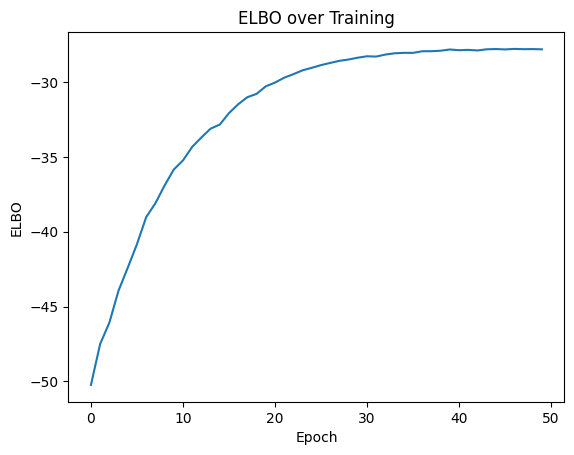

Test set ELBO: -450.2534


In [ ]:
# TODO: Implement as however you require this!
# TODO: Make sure to use the finally found optimal parameters once you submit your solution.

D_plus1 = X_train_t.shape[1] + 1
mu_param       = torch.zeros(D_plus1, requires_grad=True)
log_sigma_param = torch.zeros(D_plus1, requires_grad=True)

optimizer = torch.optim.Adam([mu_param, log_sigma_param], lr=1e-3)


EPOCHS = 50
LEARNING_RATE = 0.0001
USE_KL_TYPE: KL_DIV_TYPE = 'analytical'
elbo_history = []

for epoch in range(EPOCHS):
    epoch_elbo = 0.0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        sigma = torch.exp(log_sigma_param)
        eps = torch.randn(NUM_VARIATIONAL_SETS, D_plus1)
        elbo = ELBO(mu_param, sigma, yb, Xb, eps, kl=USE_KL_TYPE)
        loss = -elbo
        loss.backward()
        optimizer.step()
        epoch_elbo += elbo.item()
    elbo_history.append(epoch_elbo / len(train_loader))
    if epoch % 10 == 0:
        print(f"Epoch {epoch:2d} ELBO: {elbo_history[-1]:.4f}")

# Final variational parameters
final_mu = mu_param.detach()
final_sigma = torch.exp(log_sigma_param).detach()
print("Final mu:", final_mu)
print("Final sigma:", final_sigma)

# ------------------------
# 6. Evaluation & Plotting
# ------------------------
# Plot training ELBO
plt.plot(elbo_history)
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.title('ELBO over Training')
plt.show()

# ELBO on test data
eps_test = torch.randn(NUM_VARIATIONAL_SETS, D_plus1)
test_elbo = ELBO(mu_param, torch.exp(log_sigma_param), y_test_t, X_test_t, eps_test, kl=USE_KL_TYPE)
print(f"Test set ELBO: {test_elbo:.4f}")
# per sample ELBO


In [108]:
test_elbo_per_sample = test_elbo.item() / len(y_test_t)
print(f"Test set ELBO per sample: {test_elbo_per_sample:.4f}")

Test set ELBO per sample: -0.4038


# Advanced Model Evaluation (Pick <u>One</u>)

In this last part of the assignment, you should select **exactly one** of the following evaluation procedures.
Your task is to implement your chosen evaluation fully and clearly, produce within your notebook at least **one informative visualization**, and **provide a 100–500 word explanation** presenting:

- **Motivation:** Why you selected this particular evaluation.
- **Implementation:** How exactly your approach was implemented (with brief explanations for your visualization and choice of metrics).
- **Insights:** What interesting facts, strengths, or weaknesses were revealed from applying this evaluation.

-----

Pick one of the following:


1. **Visualization of Learned Low-dimensional Representations**
    * Visualize embeddings from your variational polynomial model using dimensionality reduction (e.g., PCA, t-SNE, UMAP).
    * Color embeddings by posterior uncertainty estimates or predictions.
    * This illustrates nicely how your model's uncertainty varies across regions of your feature space.
2. **Posterior Predictive Checks (PPC) (Visualizations of uncertainty)**
    * Posterior predictive checks evaluate your model by extending its sampled posterior parameters forward into the data space, then comparing the simulated data (from the posterior) with the real observed data.
3. **Evaluation of the ELBO on Hold-out Data and Bayesian (Probabilistic) Performance Metrics**
    * Evaluate the quality of your approximate posterior by evaluating ELBO on the hold-out set.
    * Bayesian performance metrics, for example: Log Predictive Density (LPD) and Bayesian Information Criterion (BIC)
4. **Posterior Weight Visualization**
    * Examine posterior distributions of your parameters (coefficients of your polynomial regression).
5. **Out-of-Distribution (OoD) Detection Capability incl. Likelihood-Based Evaluation (Density Estimation Quality)**
    * E.g., generate data points far away from the hold-out dataset and evaluate likelihood, uncertainty, etc.
    * Compare computed likelihood of the train- and hold-out dataset.
6. **Expected Calibration Error (ECE) and Calibration Curves (Reliability Diagrams)**
    * Expected Calibration Error numerically summarizes the calibration curves, giving you a single statistic to quantify how good or poor calibration of a model is.
7. **Latent Space Smoothness and Structure**
    * Generate intermediate points (linear interpolation) between latent variables from spam and non-spam messages and decode these embeddings. Good generative models produce semantically smooth interpolations.
8. **Qualitative Evaluation of a few messages**
    * Pick about ~10 messages from the holdout dataset. Among those 10, you should have some that are obviously spam, some that are ambiguous, and some that are clearly ham.
    * Evaluate the model's predictions and uncertainty about these predictions. Is there a scheme that materializes here?